In [3]:
%load_ext autoreload
%autoreload 2
from naml.modules import torch, nn, optim, tqdm
from naml.util import run_epochs
from naml import plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def f(x : torch.Tensor):
    return torch.sin(x) + x**0.8 

noise = 0.5
n_train = 50

x_train, indices = torch.sort(torch.rand(n_train) * 5)
y_train = f(x_train) + torch.normal(0, 0.5, x_train.shape) * noise

x_test = torch.linspace(0, 5, n_train)
y_true = f(x_test)

x_train, y_train

(tensor([0.0062, 0.1152, 0.3550, 0.4514, 0.5213, 0.5674, 0.8559, 1.2317, 1.2755,
         1.3290, 1.4274, 1.4304, 1.4420, 1.5188, 1.6095, 1.7108, 1.7123, 1.8077,
         1.8861, 1.9207, 1.9556, 2.1089, 2.1398, 2.1540, 2.3326, 2.4128, 2.4898,
         2.7861, 2.8574, 2.8739, 2.9305, 2.9954, 3.0809, 3.1969, 3.2171, 3.3251,
         3.3782, 3.5955, 3.6222, 3.9275, 3.9411, 3.9898, 4.0265, 4.1177, 4.2728,
         4.3192, 4.6430, 4.6716, 4.7190, 4.8255]),
 tensor([-0.1201,  0.4101,  1.2402,  0.7146,  1.2608,  1.0421,  1.2935,  2.2225,
          2.5234,  2.4360,  2.4989,  2.2563,  2.2890,  2.5780,  2.3406,  2.6892,
          2.4996,  2.5768,  2.6902,  2.2883,  2.8582,  2.8334,  2.3650,  2.1654,
          2.3898,  2.4072,  2.7063,  2.6844,  2.5878,  2.6128,  3.1962,  1.8685,
          2.0949,  2.4634,  2.3177,  2.5254,  2.7914,  2.6689,  2.6867,  2.4463,
          1.9982,  2.2815,  2.2843,  2.5238,  2.2435,  2.2569,  2.0826,  2.4061,
          2.4055,  2.2139]))

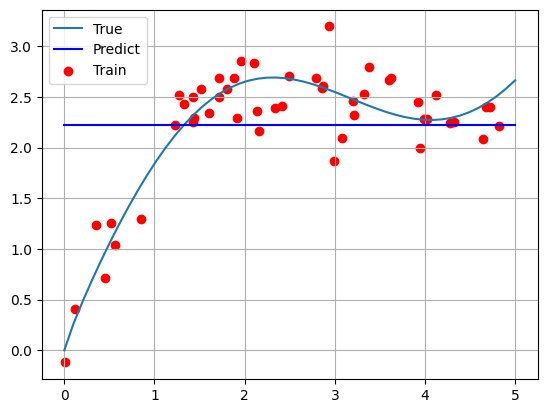

In [5]:
# Average pooling
y_hat = torch.repeat_interleave(y_train.mean(), n_train)
plot.kernel_regression(y_hat, y_true, x_test, y_train, x_train)

In [6]:
# Weighted with Gaussian kernel
x_repeat = x_test.repeat_interleave(n_train).reshape(-1, n_train)
x_repeat, x_train

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1020, 0.1020, 0.1020,  ..., 0.1020, 0.1020, 0.1020],
         [0.2041, 0.2041, 0.2041,  ..., 0.2041, 0.2041, 0.2041],
         ...,
         [4.7959, 4.7959, 4.7959,  ..., 4.7959, 4.7959, 4.7959],
         [4.8980, 4.8980, 4.8980,  ..., 4.8980, 4.8980, 4.8980],
         [5.0000, 5.0000, 5.0000,  ..., 5.0000, 5.0000, 5.0000]]),
 tensor([0.0062, 0.1152, 0.3550, 0.4514, 0.5213, 0.5674, 0.8559, 1.2317, 1.2755,
         1.3290, 1.4274, 1.4304, 1.4420, 1.5188, 1.6095, 1.7108, 1.7123, 1.8077,
         1.8861, 1.9207, 1.9556, 2.1089, 2.1398, 2.1540, 2.3326, 2.4128, 2.4898,
         2.7861, 2.8574, 2.8739, 2.9305, 2.9954, 3.0809, 3.1969, 3.2171, 3.3251,
         3.3782, 3.5955, 3.6222, 3.9275, 3.9411, 3.9898, 4.0265, 4.1177, 4.2728,
         4.3192, 4.6430, 4.6716, 4.7190, 4.8255]))

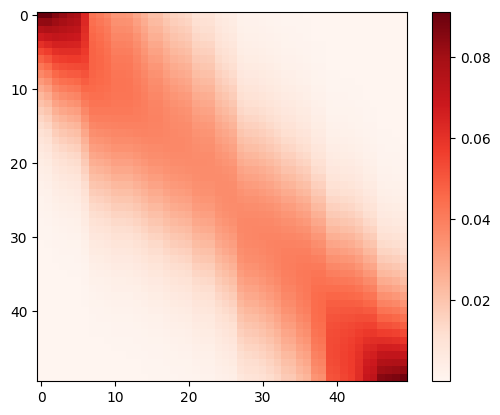

In [7]:
# Closer points have higher weights
w = nn.functional.softmax(-((x_repeat - x_train)**2) / 2, dim=1)
plot.heatmap(w)

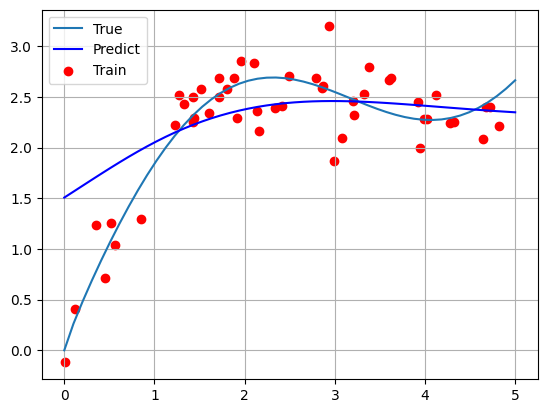

In [8]:
# Nadaraya-Watson kernel regression
y_hat = w @ y_train
plot.kernel_regression(y_hat, y_true, x_test, y_train, x_train)

In [9]:
class Net(nn.Module):
    M_w : torch.Tensor
    w : nn.Parameter

    def __init__(self):
        super().__init__()
        # Hyperparameter tuning
        # We're only learning the w parameter
        self.w = nn.Parameter(torch.randn(1), requires_grad=True)
        
    def forward(self, q : torch.Tensor, k : torch.Tensor, v : torch.Tensor):
        M_q = q.repeat_interleave(k.shape[-1]).reshape(-1, k.shape[1])
        self.M_w = M_w = nn.functional.softmax(-(((M_q - k) * self.w) **2) / 2, dim=1)
        return (M_w.unsqueeze(1) @ v.unsqueeze(-1)).reshape(-1) # Flatten
    
x_tiled = x_train.repeat((n_train,1))
y_tiled = y_train.repeat((n_train,1))

print((1-torch.eye(n_train)).bool())
k, v = x_tiled, y_tiled
print(k.shape, v.shape)
# Samples are not allowed to attend to themselves
# XXX: What if we allow this?
k, v = x_tiled[(1-torch.eye(n_train)).bool()], y_tiled[(1-torch.eye(n_train)).bool()]
k, v = k.reshape(-1, n_train-1), v.reshape(-1, n_train-1)
print(k.shape, v.shape)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]])
torch.Size([50, 50]) torch.Size([50, 50])
torch.Size([50, 49]) torch.Size([50, 49])


In [10]:
# Train
net = Net()
loss = nn.MSELoss(reduction='none')
list(net.parameters())

[Parameter containing:
 tensor([0.8956], requires_grad=True)]

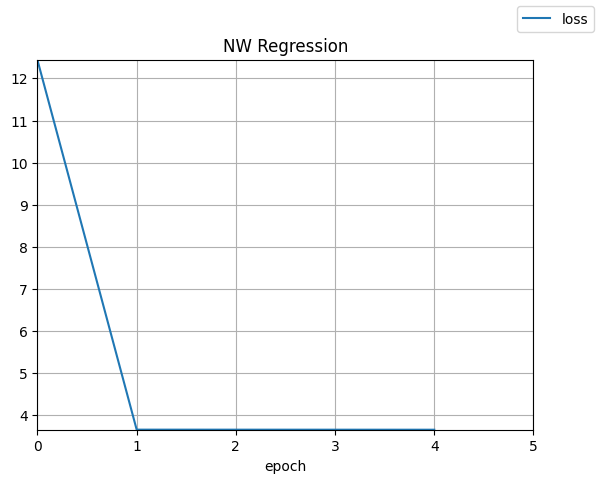

  0%|          | 0/5 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [11]:
opt = optim.SGD(net.parameters(), lr=0.5)
@run_epochs("NW Regression")
def train():
    opt.zero_grad()
    l : torch.Tensor = loss(net(x_train, k, v), y_train)
    l.sum().backward()
    opt.step()        
    return l.sum().detach()
train(5)

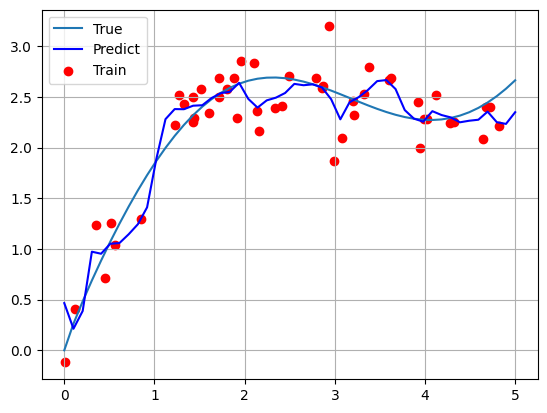

In [12]:
y_hat = net(x_test, k, v).unsqueeze(1).detach()
plot.kernel_regression(y_hat, y_true, x_test, y_train, x_train)

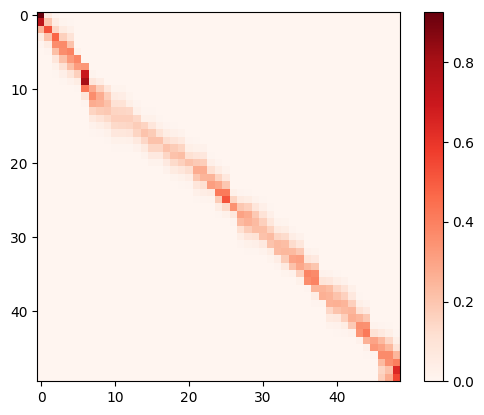

In [13]:
plot.heatmap(net.M_w)